# Dog & Cat Image Classification

For this PROJECT we're using a collection of Cats and Dogs images inspired by the classic <a href='https://www.kaggle.com/c/dogs-vs-cats'>Kaggle </a>.

The Asirra data set
Web services are often protected with a challenge that's supposed to be easy for people to solve, but difficult for computers. Such a challenge is often called a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) or HIP (Human Interactive Proof). HIPs are used for many purposes, such as to reduce email and blog spam and prevent brute-force attacks on web site passwords.

Asirra (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately. Many even think it's fun! Here is an example of the Asirra interface:

Asirra is unique because of its partnership with Petfinder.com, the world's largest site devoted to finding homes for homeless pets. They've provided Microsoft Research with over three million images of cats and dogs, manually classified by people at thousands of animal shelters across the United States. Kaggle is fortunate to offer a subset of this data for fun and research. 

Image recognition attacks
While random guessing is the easiest form of attack, various forms of image recognition can allow an attacker to make guesses that are better than random. There is enormous diversity in the photo database (a wide variety of backgrounds, angles, poses, lighting, etc.), making accurate automatic classification difficult. In an informal poll conducted many years ago, computer vision experts posited that a classifier with better than 60% accuracy would be difficult without a major advance in the state of the art. For reference, a 60% classifier improves the guessing probability of a 12-image HIP from 1/4096 to 1/459.

State of the art
The current literature suggests machine classifiers can score above 80% accuracy on this task [1]. Therfore, Asirra is no longer considered safe from attack.  We have created this contest to benchmark the latest computer vision and deep learning approaches to this problem. Can you crack the CAPTCHA? Can you improve the state of the art? Can you create lasting peace between cats and dogs?

We'll define a Convolutional Deep Nueral Network model, then feed images through a training and validation sequence using DataLoader and CUDA (Compute Unified Device Architecture).

# Import the Libraries

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import TensorDataset, DataLoader

import os
from PIL import Image #to operate on pics or images
from IPython.display import display #Only for Jupyter Notebook
import warnings
warnings.filterwarnings('ignore')



 AS MY SYS DONT HAVE CUDA SUPPORTING GPU I WILL CODE ALONG THE VARIATIONS ALONE IN THE COMMENTS :    
 
 -use ``torch.cuda.is_available()`` to check the cuda version  
 
 -to know which cuda device ``torch.cuda.current_device()``  
 
 -to know the current memory occupied in cuda ``torch.cuda.memory_allocated()``  
 
 -use the below code to assign the cuda device for the entire processing  
 
 ``device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")``

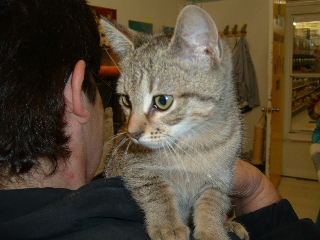

The image size is (320, 240)
The pixel value at the coordinates 0,0 of the above image is (11, 10, 8)


In [41]:
with Image.open(r'C:\Users\munikrishnan\Downloads\CATS_DOGS\train\CAT\4473.jpg') as im:
    display (im)
    print(f'The image size is {im.size}') #to know the size of the image
    print(f'The pixel value at the coordinates 0,0 of the above image is {im.getpixel((0,0))}')
    # to get the pixel value at the coordinates 0,0 in the image which will be a tuple representing teh RGB values
    

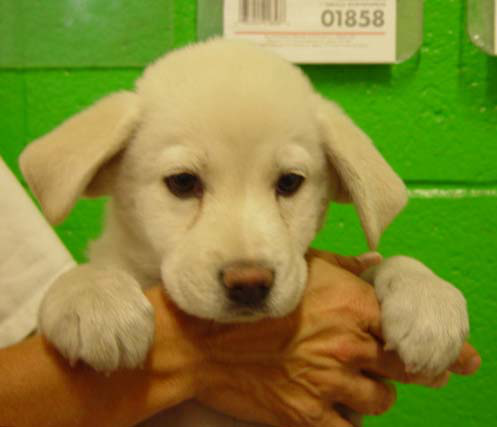

The image size is (497, 427)


In [27]:
with Image.open(r'C:\Users\munikrishnan\Downloads\CATS_DOGS\train\DOG\481.jpg') as im:
    display (im)
    print(f'The image size is {im.size}') #to know the size of the image

Now we need to collect all the file names to create a dataframe out of it for the images

In [19]:
path= "C:/Users/munikrishnan/Downloads/CATS_DOGS/"
img_names= []

for folder,subfolder,filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)

In [22]:
len(img_names)  #total number of images in the list

24994

In [43]:
img_names[0:5]

['C:/Users/munikrishnan/Downloads/CATS_DOGS/test\\CAT/10000.jpg',
 'C:/Users/munikrishnan/Downloads/CATS_DOGS/test\\CAT/10001.jpg',
 'C:/Users/munikrishnan/Downloads/CATS_DOGS/test\\CAT/10002.jpg',
 'C:/Users/munikrishnan/Downloads/CATS_DOGS/test\\CAT/10003.jpg',
 'C:/Users/munikrishnan/Downloads/CATS_DOGS/test\\CAT/10004.jpg']

Now we need to take the size of each picture 

In [28]:
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
            
    except:
        rejected.append(item)

In [29]:
len(img_sizes)

24994

From above we can see that all the image sizes has been taken nothing got rejected

In [30]:
rejected

[]

The important thing in the convolutional network is that all the images which we are gonna feed into the network has to be of similar sizes, hence we need to find a sweet spot for width and height to accomodate all the images

In [31]:
df= pd.DataFrame(img_sizes,columns=['width','height'])

In [32]:
df.head()

,width,height
0,431,360
1,500,375
2,500,471
3,500,375
4,320,240


In [34]:
df.describe()

,width,height
count,24994.000000,24994.000000
mean,404.493518,361.037129
std,108.941802,96.936811
min,42.000000,33.000000
25%,323.000000,302.000000
50%,448.000000,375.000000
75%,500.000000,421.000000
max,500.000000,500.000000


From the above statistics we can see that almost 75% of theimages have same size as the max value in both Width and Height

<div class="alert alert-block alert-info">
<b><font size="4">  Image Pre-processing: (Data Augmentation)</font></b>
</div>


The PyTorch provides ``torchvision.transforms`` functions to play with the image file by applying various operations on it. Inorder to explore that we will first load a image form the folder using the image library

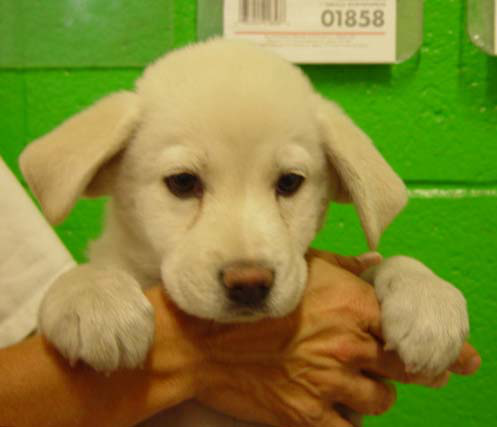

In [2]:
dog = Image.open(r'C:\Users\munikrishnan\Downloads\CATS_DOGS\train\DOG\481.jpg')
display(dog)

The simple commands which we can run on the dog variable is below to know information about the image saved in that variable:

In [46]:
dog.size # to get the size of the picture

(497, 427)

In [48]:
dog.getpixel((0,0))#to get the pixel value at the coordinates 0,0

(86, 138, 38)

As we can see that, at the coordinates 0,0 we have 3 values wich represents the RGB values of the pixel at 0,0. 

Each of these pixelholdes a tuple of 3 elements whose values will be ranges between 0 to 255

## Image Transformations

### <font color='red'>1) Tensor Conversion </font>

We can convert a image to a tensor object by using ``transforms.ToTensor()`` method

In [54]:
modify = transforms.Compose( [
    transforms.ToTensor()  #first transformation -- to convert it into tensor array
] )  

#we can use the compose method to pass series of transformations as a list on to the image instead of applying it one by one

In [55]:
tensor_pic = modify(dog) # pass the image file through this function to do the transformation
#use .cuda() fuction at the end to insitansiate the tensor in the GPU instead of CPU and follow the same whenever we create
#a tensor

In [56]:
tensor_pic

tensor([[[0.3373, 0.3412, 0.3451,  ..., 0.6118, 0.7373, 0.8039],
         [0.3333, 0.3373, 0.3412,  ..., 0.6078, 0.7333, 0.8039],
         [0.3255, 0.3294, 0.3412,  ..., 0.6039, 0.7255, 0.8078],
         ...,
         [0.4863, 0.4941, 0.4941,  ..., 0.1451, 0.1490, 0.1569],
         [0.4706, 0.4824, 0.4902,  ..., 0.1451, 0.1490, 0.1569],
         [0.4000, 0.4118, 0.4196,  ..., 0.1451, 0.1490, 0.1569]],

        [[0.5412, 0.5451, 0.5490,  ..., 0.6039, 0.7176, 0.7765],
         [0.5373, 0.5412, 0.5451,  ..., 0.6000, 0.7137, 0.7765],
         [0.5294, 0.5333, 0.5451,  ..., 0.5961, 0.7059, 0.7804],
         ...,
         [0.2275, 0.2353, 0.2353,  ..., 0.4745, 0.4784, 0.4863],
         [0.2118, 0.2235, 0.2314,  ..., 0.4745, 0.4784, 0.4863],
         [0.1412, 0.1529, 0.1608,  ..., 0.4745, 0.4784, 0.4863]],

        [[0.1490, 0.1529, 0.1569,  ..., 0.3725, 0.4980, 0.5647],
         [0.1451, 0.1490, 0.1529,  ..., 0.3686, 0.4941, 0.5647],
         [0.1373, 0.1412, 0.1529,  ..., 0.3647, 0.4863, 0.

As we can see above, the picture in the variable 'dog' is transformed in to a Tensor array by using the ``transforms.ToTensor()`` method. Now lets check the Tensor array and plot it back whether it is the same picture

In [57]:
type(tensor_pic)

torch.Tensor

In [59]:
tensor_pic.shape

torch.Size([3, 427, 497])

The above result of the ``tensor.shape`` indicates that there are 3 color channels with a  width of 497 and a height of 427.   
Now lets replot it using Imshow 

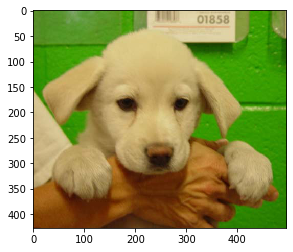

In [60]:
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

 So we have converted an image into a Tensor object using ``transforms`` method and replotted the same

Now lets look at the pixel range in the transformed Tensor, because by default during the tensor conversion process the ``transforms`` function will
normalize the pixel values to 0 to 1 from 0 to 255 (original image)

In [83]:
print(f'\nThe original image\'s pixel values at the co-ordiantes  0,0  is {dog.getpixel((0,0))} and each values ranges form 0 to 255\n')
print(f"""The tensor matrix\'s pixel values at the co-ordiantes  0,0  is {tensor_pic[:,0,0].numpy()} where all the values are 
normalized by the max value of 255\n""")

#lets take the pixel at the coordinate 0,0 as like in the original image


The original image's pixel values at the co-ordiantes  0,0  is (86, 138, 38) and each values ranges form 0 to 255

The tensor matrix's pixel values at the co-ordiantes  0,0  is [0.3372549  0.5411765  0.14901961] where all the values are 
normalized by the max value of 255



###  <font color='red'>2) Image Resizing </font>

We can resize a image by using ``transforms.Resize(size)`` method.   

First we will print the image with the current size

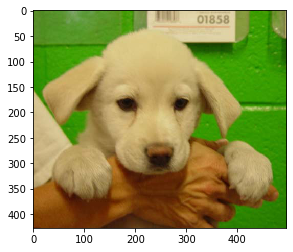

In [85]:
modify = transforms.Compose( [transforms.ToTensor()] ) 
tensor_pic = modify(dog)
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

Note that the width is more than 400 and height is more than 400 as well. Now we will use the ``transforms.Resize()`` function to resize the image as below

In [87]:
modify = transforms.Compose( [
    transforms.Resize( (350,300)), # first transformation  -- to resize the image
    transforms.ToTensor()            # second transformation -- to convert it into tensor array
] )  

#we can use the compose method to pass series of transformations as a list on to the image instead of applying it one by one

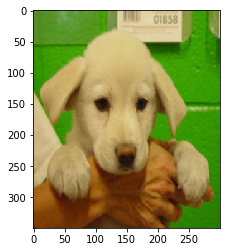

In [88]:
tensor_pic= modify(dog)
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

See that the width and height of the image has been changed to the specified dimensions

##  <font color='red'> 3) Image Cropping </font > 

We can crop the image at the center by using a specified square matrices dimension using the ``transforms.CenterCrop()`` method.

First we will print the original image

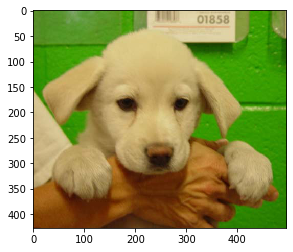

In [90]:
modify = transforms.Compose( [transforms.ToTensor()] ) 
tensor_pic = modify(dog)
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

In [91]:
modify = transforms.Compose( [
    transforms.CenterCrop(250),      # first transformation  -- to crop the image at center of dim 250X250
    transforms.ToTensor()            # second transformation -- to convert it into tensor array
] )  

#we can use the compose method to pass series of transformations as a list on to the image instead of applying it one by one

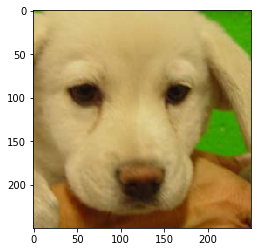

In [92]:
tensor_pic= modify(dog)
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

## <font color='red'> 4) Image Reflection (Horizontal/Vertical) Flip </font>


We can flip the image horizontally by using  the ``transforms.RandomHorizontalFlip()`` method. Why Random? sometimes we will pass
a bunch of images though list to the ``transforms`` function and we wanna do the horizontal flip for only few of the images but not for all, In that case
we can specify the probability at which the images will be chosen at random and apply the flip transformation

First we will print the original image

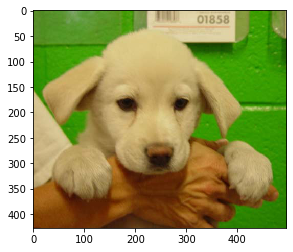

In [95]:
modify = transforms.Compose( [transforms.ToTensor()] ) 
tensor_pic = modify(dog)
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

In [96]:
modify = transforms.Compose( [
    transforms.RandomHorizontalFlip(p=1),  # first transformation  -- to flip the image (probability is 1 for illustration)
    transforms.ToTensor()                  # second transformation -- to convert it into tensor array
] )  

#we can use the compose method to pass series of transformations as a list on to the image instead of applying it one by one

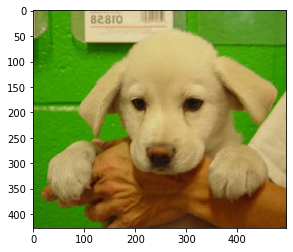

In [97]:
tensor_pic= modify(dog)
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

In [98]:
modify = transforms.Compose( [
    transforms.RandomVerticalFlip(p=1),  # first transformation  -- to flip the image (probability is 1 for illustration)
    transforms.ToTensor()                  # second transformation -- to convert it into tensor array
] )  

#we can use the compose method to pass series of transformations as a list on to the image instead of applying it one by one

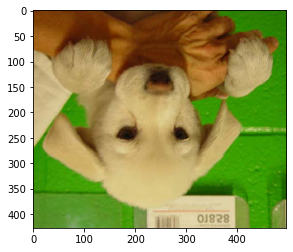

In [99]:
tensor_pic= modify(dog)
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

## <font color='red'>5) Image Rotation </font>


We can rotate the image at the center by a specified degree using the ``transforms.RandomRotation()`` method.

First we will print the original image

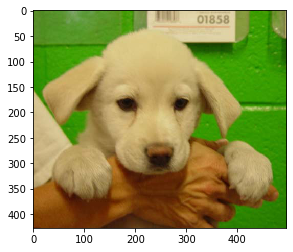

In [101]:
modify = transforms.Compose( [transforms.ToTensor()] ) 
tensor_pic = modify(dog)
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

In [102]:
modify = transforms.Compose( [
    transforms.RandomRotation(degrees = 30),  # first transformation  -- to rotate the image 
    transforms.ToTensor()                  # second transformation -- to convert it into tensor array
] )  

#we can use the compose method to pass series of transformations as a list on to the image instead of applying it one by one

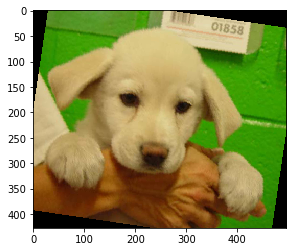

In [103]:
tensor_pic= modify(dog)
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

## <font color='red'>6) Color Jitters </font>


We can rotate the image at the center by a specified degree using the ``transforms.ColorJitter(brightness, contrast, saturation, hue)`` method.

First we will print the original image

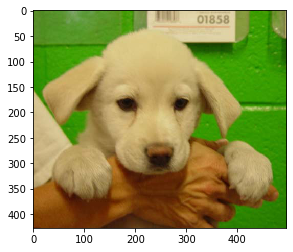

In [3]:
modify = transforms.Compose( [transforms.ToTensor()] ) 
tensor_pic = modify(dog)
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

In [17]:
modify = transforms.Compose( [
    transforms.ColorJitter(brightness=0.5, contrast=0.4, saturation=0.2, hue= 0.5),  # first transformation  -- to change the color of the image 
    transforms.ToTensor()                  # second transformation -- to convert it into tensor array
] )  

#we can use the compose method to pass series of transformations as a list on to the image instead of applying it one by one

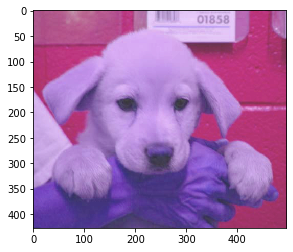

In [18]:
tensor_pic= modify(dog)
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

## <font color='red'>Multiple Transformations </font>
 

In [105]:
modify = transforms.Compose( [
    transforms.RandomHorizontalFlip(p=1),     # Frist transformation -- flip horizontally  
    transforms.RandomRotation(degrees = 30),  # Second transformation  -- to rotate the image to 30 degrees
    transforms.Resize( (300,290)),            # Third transformation --Resize to 300x290
    transforms.CenterCrop(250) ,              # Fourth transformation --Cropping at the center by 250x250   
    transforms.ToTensor()                     # Last transformation -- to convert it into tensor array (make sure the tensor converion is at the last step)
] ) 

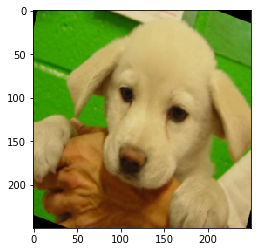

In [106]:
tensor_pic= modify(dog)
plt.imshow(np.transpose(tensor_pic.numpy(),(1,2,0)))

## Loading the Dataset using TorchVision

In [107]:
from torchvision import datasets, transforms


In [108]:
# TRAINING DATA TRANSFORMATION
train_transform =transforms.Compose( [
    transforms.RandomHorizontalFlip(),     # Frist transformation -- flip horizontally  
    transforms.RandomRotation(degrees = 30),  # Second transformation  -- to rotate the image to 30 degrees
    transforms.Resize( (224)),                # Third transformation --Resize to 224 as the mean in the describe function above
    transforms.CenterCrop(224) ,              # Fourth transformation --Cropping at the center by 250x250   
    transforms.ToTensor(),                     # Fifth transformation -- to convert it into tensor array (make sure the tensor converion is at the last step)
    transforms.Normalize( [0.485,0.456,0.406],[0.229,0.224,0.225]) # Sixth transformation -- normalize the data to the specified mean and std dev

] ) 

In [109]:
# TESTING DATA TRANSFORMATION
test_transform =transforms.Compose( [
    transforms.Resize( (224)),                # First transformation --Resize to 224 as the mean in the describe function above
    transforms.CenterCrop(224) ,              # Second transformation --Cropping at the center by 250x250   
    transforms.ToTensor(),                    # Third transformation -- to convert it into tensor array (make sure the tensor converion is at the last step)
    transforms.Normalize( [0.485,0.456,0.406],[0.229,0.224,0.225]) # Fourth transformation -- normalize the data to the specified mean and std dev

] ) 

We're going to take advantage of a built-in torchvision dataset tool called <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder'><tt><strong>ImageFolder</strong></tt></a>.

In [111]:
root = r'C:\Users\munikrishnan\Downloads\CATS_DOGS'

In [112]:
train_data = datasets.ImageFolder(os.path.join(root,'train'),transform= train_transform)
test_data  = datasets.ImageFolder(os.path.join(root,'test'),transform = test_transform)

In [113]:
train_data

Dataset ImageFolder
    Number of datapoints: 18743
    Root location: C:\Users\munikrishnan\Downloads\CATS_DOGS\train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [114]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [115]:
len(train_data)

18743

In [116]:
test_data

Dataset ImageFolder
    Number of datapoints: 6251
    Root location: C:\Users\munikrishnan\Downloads\CATS_DOGS\test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [117]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([3, 224, 224]) 
Label: 0


In [118]:
image, label = test_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([3, 224, 224]) 
Label: 0


From the above result we can see that the dimension of the image is ``3 x 224x 224`` which indicates that the ``height = 224``, ``widith  = 224`` and ``color channel is 3`` which is Red,Green and Blue(RGB)

In [121]:
class_names= train_data.classes #as we loaded from the folder structure, the names will be stored as classes
class_names

['CAT', 'DOG']

Label: [    1     1     1     1     0     1     0     1     0     1]
Class:  DOG DOG DOG DOG CAT DOG CAT DOG CAT DOG


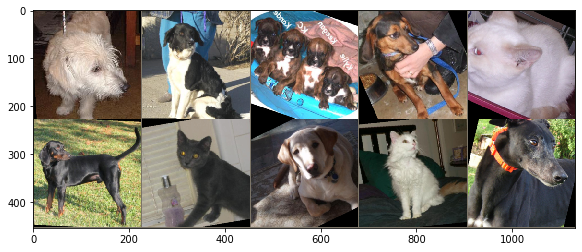

In [123]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array
from torchvision.utils import make_grid
# Grab the first  10 images from the first batch of training data
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8

inv_normalize = transforms.Normalize(mean= [ -0.485/0.229 , -0.456/0.224,-0.406/0.225 ], std=[1/0.229, 1/0.224,1/0.225])
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

We can see that some of the images are rotated and flipped randomly by the ``transforms`` functions

# Data Loading Strategy

As there are more than 30k rows its not wise to feed all the data once into the CNN model. Instead we will try to feed the data in batches to the model using Dataset and DataLoader feature of Torch library

In [119]:
from torch.utils.data import TensorDataset, DataLoader

In [120]:
"""
Initializing train/test dataloader object which splits the training/testing datasets into small batches of 10 images each
and this can be used later in the CNN model  
"""
torch.manual_seed(101)
bat_sz=10
train_loader = DataLoader(train_data,batch_size=bat_sz,shuffle=True)  #use pin_memory=True in the parameters after shuffle to change to cuda
test_loader = DataLoader(test_data,batch_size=bat_sz,shuffle=False)   #use pin_memory=True in the parameters after shuffle to change to cuda

# Define the CNN Model

In [127]:
class CONVNN(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1  = nn.Conv2d(3, 10 , kernel_size =5, stride=1,padding=2)#3 color channels as input and We will be using 5X5 filter/kernel and stride of 1 without any padding 
        self.conv2  = nn.Conv2d(10, 16, 5 , 1,padding=2)
        self.layer1 = nn.Linear(56*56*16,120) # we need to calculate the resulting number of matrices passing thru the conv layer and put that corressponding o/p as the linear layer input
        self.layer2 = nn.Linear(120,84)
        self.layer3 = nn.Linear(84,2) #only 2 classes of Dogs and Cats
        
    def forward(self,x):
        
        x= F.max_pool2d(  F.relu(self.conv1(x)) , 2, 2) #adding relu and max pooling with 2x2 kernel and stride of 2
        x= F.max_pool2d(  F.relu(self.conv2(x)) , 2, 2) #adding relu and max pooling the same line
        x= F.relu(      self.layer1(  x.view(-1,56*56*16)   ))       #flattening by using View and no dropout has been added
        x= F.relu(self.layer2(x))
        x= F.log_softmax(  self.layer3(x), dim=1)          #Binary class classificaiton
        
        return x
    

### How the input parameters for the linear layer is calcualted:    
At first we have 224X224 image which was filtered by 5X5 kernel as we do have padding so the last 4 pixels will be 
scanned thus the resulting image of the kernel will be (224)X(224)then it is passed to the max_pool where it reduced half or what was there before hence the output
will be  (224/2 X 224/2) = (112X112) then again we will have a conv layer which is scanned by a 5X5 kernel then max pooling occurs so ( 112/2 X 112/2) = (56X56). finally the input layer of Linear will take 56X56 matrix of image with the number of conv layers just
before the linear layer is 16 = > 16*56*56

Padding will be calculated P= (K-1)/2 Where K is the Kernel's filter size  

here, k=5 so P = (5-1)/2 = 2

In the above model, due to my computer limitations, i stopped at just 2 Convolutional layers, 2 Pooling layers and 2 Fully connected layers but we can add as much as we want to increase the accuracy of the model

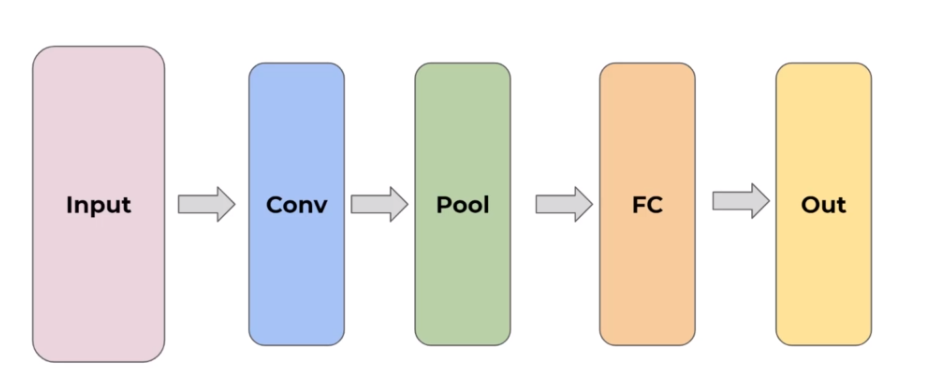

In [128]:
torch.manual_seed(101)
model = CONVNN()  #to instansiate the model as cuda use "model = CONVNN().to(device) " or "model.cuda()" so that whatever the tensors we are passing to the model will be saved in GPU and operations will be performed on that
model

CONVNN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(10, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layer1): Linear(in_features=50176, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=84, bias=True)
  (layer3): Linear(in_features=84, out_features=2, bias=True)
)

# Define Loss and Optimizer

In [129]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

# Training the CNN Model

In [130]:
epochs = 4
train_loss= []
test_loss= []
train_acc=[]
test_acc = []

print(f'\nConvolutional Neural Network Model Metrics:\n')
print(f'\t This CNN model configuration has {epochs} epochs with each batch size of {bat_sz} images:\n')
for i in range(epochs):
    
    train_crt_pred = 0
    test_crt_pred = 0
    conf_mat= torch.FloatTensor([])
    
    for b,(x_train,y_train) in enumerate (train_loader):
        b += 1
        y_pred = model.forward(x_train)
        loss= criterion(y_pred,y_train)
        
        buffer = torch.max(y_pred.data, 1) [1]
        batch_acc = (buffer == y_train).sum()
        train_crt_pred +=  batch_acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        if b%  int((len(train_data)/bat_sz)/5 )  == 0:
            print(f'Epoch{i+1:2} Batch {b:4} loss: {loss.item():5.2f} Train Accuracy: {train_crt_pred.item()*100/(bat_sz*b):6.3f}%')
    
    train_loss.append(loss)  #loss after 1 epoch
    train_acc.append(train_crt_pred) # crt predictions after 1 epoch
    
    
    with torch.no_grad():  #testing after 1 complete epoch
        for b,(x_test,y_test) in enumerate (test_loader):
            b += 1
            y_eval = model(x_test)
            loss= criterion(y_eval,y_test)
            buffer1 = torch.max(y_eval.data, 1) [1]
            conf_mat =  torch.cat((conf_mat.float(),buffer1.float()),0)
            batch_acc = (buffer1 == y_test).sum()
            test_crt_pred +=  batch_acc
    
    test_loss.append(loss) #test loss after the last completed epoch
    test_acc.append(test_crt_pred) # crt predictions using the last completed epoch

    print(f'After {i+1} Epoch(s) the Train Accuracy is {(train_crt_pred.item()/len(train_data))*100:6.3f}% and Test Accuracy is {(test_crt_pred.item()/len(test_data))*100:6.3f}% \n')     
    
        


Convolutional Neural Network Model Metrics:

	 This CNN model configuration has 4 epochs with each batch size of 10 images:

Epoch 1 Batch  374 loss:  0.69 Train Accuracy: 52.834%
Epoch 1 Batch  748 loss:  0.71 Train Accuracy: 55.334%
Epoch 1 Batch 1122 loss:  0.62 Train Accuracy: 57.282%
Epoch 1 Batch 1496 loss:  0.58 Train Accuracy: 59.151%
Epoch 1 Batch 1870 loss:  0.53 Train Accuracy: 60.348%
After 1 Epoch(s) the Train Accuracy is 60.343% and Test Accuracy is 59.670% 

Epoch 2 Batch  374 loss:  0.52 Train Accuracy: 67.086%
Epoch 2 Batch  748 loss:  0.56 Train Accuracy: 67.767%
Epoch 2 Batch 1122 loss:  0.63 Train Accuracy: 67.879%
Epoch 2 Batch 1496 loss:  0.30 Train Accuracy: 68.717%
Epoch 2 Batch 1870 loss:  0.78 Train Accuracy: 69.155%
After 2 Epoch(s) the Train Accuracy is 69.140% and Test Accuracy is 72.916% 

Epoch 3 Batch  374 loss:  0.63 Train Accuracy: 71.230%
Epoch 3 Batch  748 loss:  0.72 Train Accuracy: 71.471%
Epoch 3 Batch 1122 loss:  0.43 Train Accuracy: 71.925%
Epo

After 4 eochs the ACCURACY was keep on raising, so we can run more epochs if we must but for my computer limitations am gonna stop here.

# Model Evaluation

In [131]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

In [132]:
torch.Tensor([r for q,r in test_data])

tensor([0., 0., 0.,  ..., 1., 1., 1.])


The Confusion Matrix is plotted below:


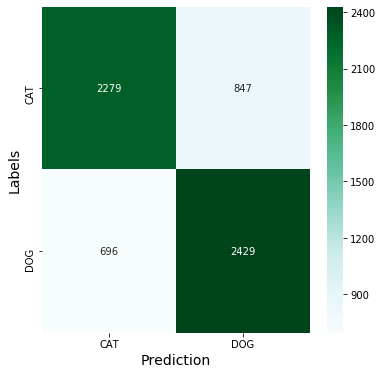


The Classification Report is plotted below: 

               precision    recall  f1-score   support

         0.0       0.77      0.73      0.75      3126
         1.0       0.74      0.78      0.76      3125

    accuracy                           0.75      6251
   macro avg       0.75      0.75      0.75      6251
weighted avg       0.75      0.75      0.75      6251



In [133]:
print('\nThe Confusion Matrix is plotted below:')
cfmt =pd.DataFrame(confusion_matrix(torch.Tensor([r for q,r in test_data]).reshape(-1,1),conf_mat.reshape(-1,1),labels=[0,1]),index=class_names,columns=class_names)
plt.figure(figsize=(6,6))
sns.heatmap(cfmt,annot=True,cmap='BuGn',fmt="d")
plt.xlabel("Prediction",fontsize=14)
plt.ylabel("Labels",fontsize=14)
plt.show()
print('\nThe Classification Report is plotted below: \n\n',classification_report(torch.Tensor([r for q,r in test_data]).reshape(-1,1),conf_mat.reshape(-1,1)))


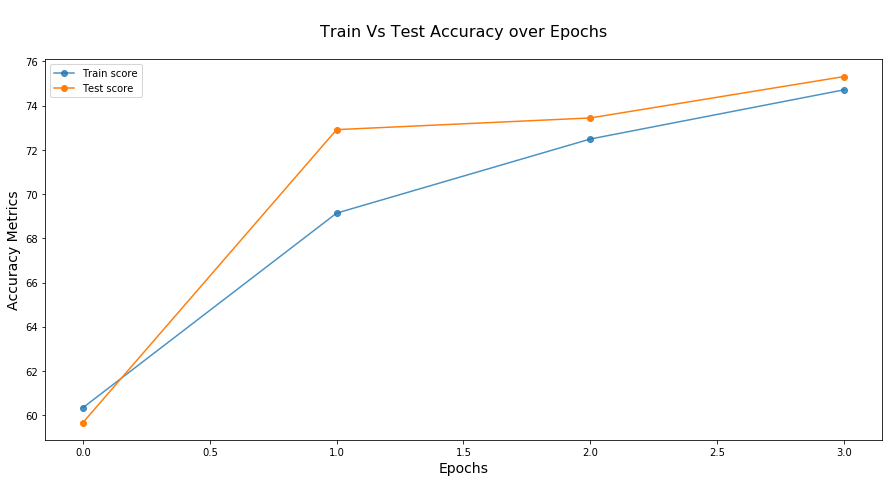

In [134]:
plt.figure(figsize=(15,7))
plt.plot([(t/(len(train_data)/100)) for t in train_acc], label='Train score',marker='o',alpha=0.8)
plt.plot([(t/(len(test_data)/100)) for t in test_acc], label='Test score',marker='o')
plt.title('\nTrain Vs Test Accuracy over Epochs\n',fontsize=16)
# plt.xticks(np.arange(0,20,1));
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy Metrics',fontsize=14)
plt.legend();

From above we can see that, at the epoch 4 we have better Test results we can run more epochs if necessary

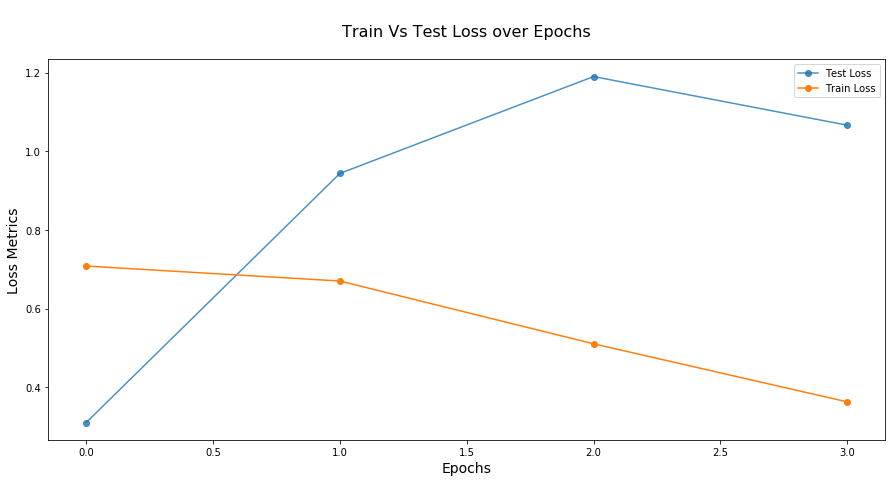

In [135]:
plt.figure(figsize=(15,7))
plt.plot([t for t in test_loss], label='Test Loss',marker='o',alpha=0.8)
plt.plot([t for t in train_loss], label='Train Loss',marker='o')
plt.title('\nTrain Vs Test Loss over Epochs\n',fontsize=16)
# plt.xticks(np.arange(0,20,1));
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss Metrics',fontsize=14)
plt.legend();

# Save the Model

In [136]:
torch.save(model.state_dict(), 'DOGSNCATS_CNN.pt')

<div class="alert alert-block alert-info">
<b><font size="4"> Alex Net - PreTrained CNN </font></b>
</div>


## Download a pretrained model
Torchvision has a number of proven models available through <a href='https://pytorch.org/docs/stable/torchvision/models.html#classification'><tt><strong>torchvision.models</strong></tt></a>:
<ul>
<li><a href="https://arxiv.org/abs/1404.5997">AlexNet</a></li>
<li><a href="https://arxiv.org/abs/1409.1556">VGG</a></li>
<li><a href="https://arxiv.org/abs/1512.03385">ResNet</a></li>
<li><a href="https://arxiv.org/abs/1602.07360">SqueezeNet</a></li>
<li><a href="https://arxiv.org/abs/1608.06993">DenseNet</a></li>
<li><a href="https://arxiv.org/abs/1512.00567">Inception</a></li>
<li><a href="https://arxiv.org/abs/1409.4842">GoogLeNet</a></li>
<li><a href="https://arxiv.org/abs/1807.11164">ShuffleNet</a></li>
<li><a href="https://arxiv.org/abs/1801.04381">MobileNet</a></li>
<li><a href="https://arxiv.org/abs/1611.05431">ResNeXt</a></li>
</ul>
These have all been trained on the <a href='http://www.image-net.org/'>ImageNet</a> database of images. Our only task is to reduce the output of the fully connected layers from (typically) 1000 categories to just 2.

To access the models, you can construct a model with random weights by calling its constructor:<br>
<pre>resnet18 = models.resnet18()</pre>
You can also obtain a pre-trained model by passing pretrained=True:<br>
<pre>resnet18 = models.resnet18(pretrained=True)</pre>
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

For its simplicity and effectiveness, we'll use AlexNet:

In [140]:

AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\munikrishnan/.cache\torch\checkpoints\alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

The above results shows the infrastructure of the ``AlexNet`` CNN with preloaded weights and Biases so during our training we should not 
change its weight and biases. Hence we need to freeze it by using the below commands

<div class="alert alert-info">This model uses <a href='https://pytorch.org/docs/master/nn.html#torch.nn.AdaptiveAvgPool2d'><tt><strong>torch.nn.AdaptiveAvgPool2d(<em>output_size</em>)</strong></tt></a> to convert the large matrix coming out of the convolutional layers to a (6x6)x256 matrix being fed into the fully connected layers.</div>

In [141]:
for param in AlexNetmodel.parameters(): #We set .requires_grad to False so we don't backprop through them
    param.requires_grad = False

In the AlexNet model only the ``classifier`` part is customizable to change to binary output. 

Note that when we assign new layers, their parameters default to <tt>.requires_grad=True</tt>.

In [142]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

The modification has been done successfully

In [143]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)


as we need to only optimize the classifier's weights and biases we will mention ``AlexNetmodel.classifier.parameters()``

## Train the AlexNet Model

As we will be updating only the weights and biases of the neural network layers the training time will be less

In [144]:
epochs = 3
train_loss= []
test_loss= []
train_acc=[]
test_acc = []

print(f'\nConvolutional Neural Network Model Metrics:\n')
print(f'\t This CNN model configuration has {epochs} epochs with each batch size of {bat_sz} images:\n')
for i in range(epochs):
    
    train_crt_pred = 0
    test_crt_pred = 0
    conf_mat= torch.FloatTensor([])
    
    for b,(x_train,y_train) in enumerate (train_loader):
        b += 1
        y_pred = AlexNetmodel.forward(x_train)
        loss= criterion(y_pred,y_train)
        
        buffer = torch.max(y_pred.data, 1) [1]
        batch_acc = (buffer == y_train).sum()
        train_crt_pred +=  batch_acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        if b%  int((len(train_data)/bat_sz)/5 )  == 0:
            print(f'Epoch{i+1:2} Batch {b:4} loss: {loss.item():5.2f} Train Accuracy: {train_crt_pred.item()*100/(bat_sz*b):6.3f}%')
    
    train_loss.append(loss)  #loss after 1 epoch
    train_acc.append(train_crt_pred) # crt predictions after 1 epoch
    
    
    with torch.no_grad():  #testing after 1 complete epoch
        for b,(x_test,y_test) in enumerate (test_loader):
            b += 1
            y_eval = AlexNetmodel(x_test)
            loss= criterion(y_eval,y_test)
            buffer1 = torch.max(y_eval.data, 1) [1]
            conf_mat =  torch.cat((conf_mat.float(),buffer1.float()),0)
            batch_acc = (buffer1 == y_test).sum()
            test_crt_pred +=  batch_acc
    
    test_loss.append(loss) #test loss after the last completed epoch
    test_acc.append(test_crt_pred) # crt predictions using the last completed epoch

    print(f'After {i+1} Epoch(s) the Train Accuracy is {(train_crt_pred.item()/len(train_data))*100:6.3f}% and Test Accuracy is {(test_crt_pred.item()/len(test_data))*100:6.3f}% \n')     
    
        


Convolutional Neural Network Model Metrics:

	 This CNN model configuration has 3 epochs with each batch size of 10 images:

Epoch 1 Batch  374 loss:  0.23 Train Accuracy: 89.733%
Epoch 1 Batch  748 loss:  0.03 Train Accuracy: 91.471%
Epoch 1 Batch 1122 loss:  0.01 Train Accuracy: 92.086%
Epoch 1 Batch 1496 loss:  0.02 Train Accuracy: 92.480%
Epoch 1 Batch 1870 loss:  0.18 Train Accuracy: 92.743%
After 1 Epoch(s) the Train Accuracy is 92.755% and Test Accuracy is 95.185% 

Epoch 2 Batch  374 loss:  0.08 Train Accuracy: 93.476%
Epoch 2 Batch  748 loss:  0.45 Train Accuracy: 93.944%
Epoch 2 Batch 1122 loss:  0.07 Train Accuracy: 93.815%
Epoch 2 Batch 1496 loss:  0.02 Train Accuracy: 93.496%
Epoch 2 Batch 1870 loss:  0.48 Train Accuracy: 93.556%
After 2 Epoch(s) the Train Accuracy is 93.550% and Test Accuracy is 94.865% 

Epoch 3 Batch  374 loss:  0.21 Train Accuracy: 94.545%
Epoch 3 Batch  748 loss:  0.07 Train Accuracy: 94.238%
Epoch 3 Batch 1122 loss:  0.08 Train Accuracy: 94.144%
Epo

From the results of customized Alexnet Neural network we get better results than the developed one

## AlexNet Model Evaluation


The Confusion Matrix is plotted below:


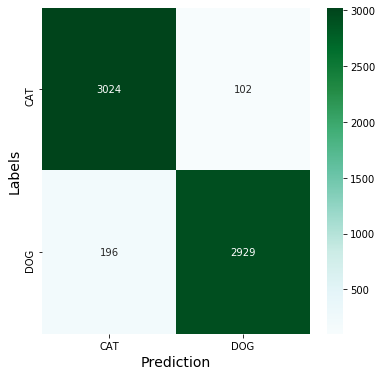


The Classification Report is plotted below: 

               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      3126
         1.0       0.97      0.94      0.95      3125

    accuracy                           0.95      6251
   macro avg       0.95      0.95      0.95      6251
weighted avg       0.95      0.95      0.95      6251



In [146]:
print('\nThe Confusion Matrix is plotted below:')
cfmt =pd.DataFrame(confusion_matrix(torch.Tensor([r for q,r in test_data]).reshape(-1,1),conf_mat.reshape(-1,1),labels=[0,1]),index=class_names,columns=class_names)
plt.figure(figsize=(6,6))
sns.heatmap(cfmt,annot=True,cmap='BuGn',fmt="d")
plt.xlabel("Prediction",fontsize=14)
plt.ylabel("Labels",fontsize=14)
plt.show()
print('\nThe Classification Report is plotted below: \n\n',classification_report(torch.Tensor([r for q,r in test_data]).reshape(-1,1),conf_mat.reshape(-1,1)))


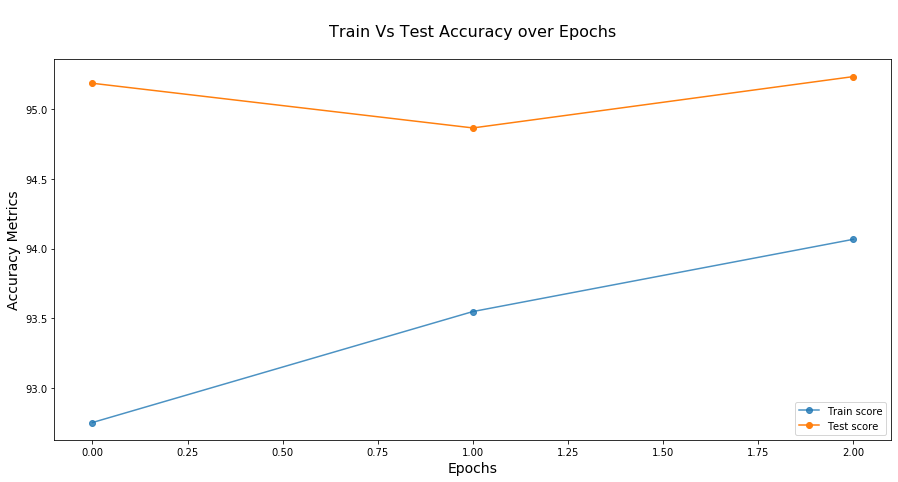

In [147]:
plt.figure(figsize=(15,7))
plt.plot([(t/(len(train_data)/100)) for t in train_acc], label='Train score',marker='o',alpha=0.8)
plt.plot([(t/(len(test_data)/100)) for t in test_acc], label='Test score',marker='o')
plt.title('\nTrain Vs Test Accuracy over Epochs\n',fontsize=16)
# plt.xticks(np.arange(0,20,1));
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy Metrics',fontsize=14)
plt.legend();

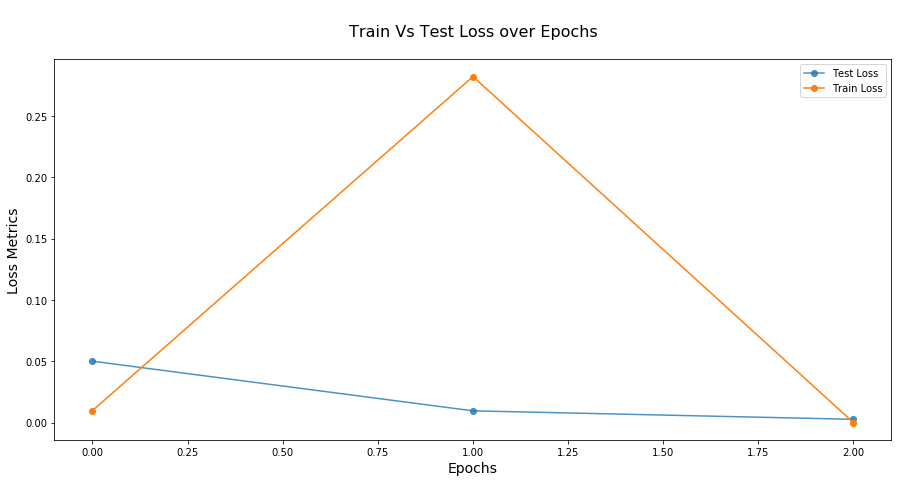

In [148]:
plt.figure(figsize=(15,7))
plt.plot([t for t in test_loss], label='Test Loss',marker='o',alpha=0.8)
plt.plot([t for t in train_loss], label='Train Loss',marker='o')
plt.title('\nTrain Vs Test Loss over Epochs\n',fontsize=16)
# plt.xticks(np.arange(0,20,1));
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss Metrics',fontsize=14)
plt.legend();

## Prediction for a new image

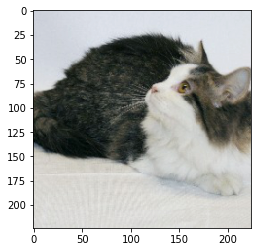

In [149]:
x = 2019
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [150]:
# CNN Model Prediction:

model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} is {class_names[new_pred.item()]}')

Predicted value: 0 is CAT


In [151]:
# AlexNet Model Prediction:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} is {class_names[new_pred.item()]}')

Predicted value: 0 is CAT
